Yao proposed an AB model that I think is equivalent to noisy percentile. Andrew Hearin proposed noisy percentile as an AB model to me during the KITP, but there was a reason that I ended up rejecting it as a possiblity, and he agreed. However, I deleted my notes on the topic, so I need to redo it to see why I ended up rejecting it. 

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
from pearce.mocks import cat_dict
import numpy as np

In [3]:
from halotools.empirical_models import noisy_percentile
from halotools.utils.table_utils import compute_prim_haloprop_bins

In [4]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[1.0]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

In [5]:
cat.load(1.0, HOD='hsabRedMagic')

In [6]:
fiducial_point = {'logM0': 12.0, 'logM1': 13.2, 'alpha': 1.02,
                      'logMmin': 12.0, 'f_c':1.0, 'sigma_logM': 0.60}

In [7]:
fiducial_point['mean_occupation_centrals_assembias_param1'] = 1.0
fiducial_point['mean_occupation_satellites_assembias_param1'] = 1.0

In [8]:
hod_params = dict(fiducial_point)
cat.populate(hod_params)

In [9]:
cen_occ = cat.model.model_dictionary['centrals_occupation']

In [10]:
prim_haloprop = cat.halocat.halo_table[cen_occ.prim_haloprop_key]
sec_haloprop = cat.halocat.halo_table[cen_occ.sec_haloprop_key]

In [11]:
prim_haloprop_bins = compute_prim_haloprop_bins(prim_haloprop = prim_haloprop)

In [12]:
baseline_result = cen_occ.baseline_mean_occupation(prim_haloprop = prim_haloprop)
split = cen_occ.percentile_splitting_function(prim_haloprop = prim_haloprop)

In [13]:
final_result = cen_occ.mean_occupation(prim_haloprop = prim_haloprop, sec_haloprop = sec_haloprop)

In [14]:
bin_slice = prim_haloprop_bins%5 == 0

In [15]:
pal = sns.cubehelix_palette(len(set(prim_haloprop_bins[bin_slice])), rot=-.5, dark=.3)

In [16]:
random_idxs = np.random.choice(prim_haloprop_bins[bin_slice].shape[0], 10000, replace=False)

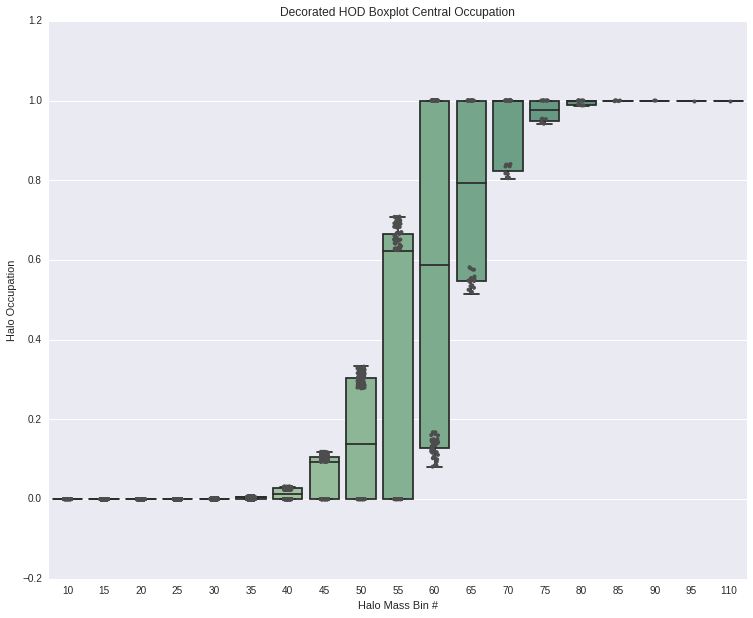

In [17]:
fig = plt.figure(figsize = (12.5,10))
#plt.plot(prim_haloprop_bins[bin_slice][sorted_idxs], baseline_result[bin_slice][sorted_idxs])
ax = sns.boxplot(x = prim_haloprop_bins[bin_slice], y = final_result[bin_slice], palette=pal)
sns.stripplot(x = prim_haloprop_bins[bin_slice][random_idxs], y = final_result[bin_slice][random_idxs],
              jitter=True, size=4, color=".3", linewidth=0)
sns.plt.title('Decorated HOD Boxplot Central Occupation')
sns.plt.xlabel('Halo Mass Bin #')
sns.plt.ylabel('Halo Occupation')

In [18]:
from halotools.utils import rank_order_percentile

In [19]:
A = 0.0

In [20]:
baseline_upper_bound = 1.0
baseline_lower_bound = 0.0
def percentile_perturbation(sec_haloprop, baseline_result, splitting_result):
    perturbation = np.zeros(len(sec_haloprop))
    sh_perc = rank_order_percentile(sec_haloprop)

    strength = noisy_percentile(sh_perc, correlation_coeff = A) -0.5
    positive_strength_idx = strength > 0
    negative_strength_idx = strength < 0

    if len(baseline_result[positive_strength_idx]) > 0:
        base_pos = baseline_result[positive_strength_idx]
        split_pos = splitting_result[positive_strength_idx]
        type1_frac_pos = 1 - split_pos
        strength_pos = strength[positive_strength_idx]

        upper_bound1 = baseline_upper_bound - base_pos
        upper_bound2 = ((1 - type1_frac_pos)/type1_frac_pos)*(base_pos - baseline_lower_bound)
        upper_bound = np.minimum(upper_bound1, upper_bound2)
        perturbation[positive_strength_idx] = strength_pos*upper_bound

    if len(baseline_result[negative_strength_idx]) > 0:
        base_neg = baseline_result[negative_strength_idx]
        split_neg = splitting_result[negative_strength_idx]
        type1_frac_neg = 1 - split_neg
        strength_neg = strength[negative_strength_idx]

        lower_bound1 = baseline_lower_bound - base_neg
        lower_bound2 = (1 - type1_frac_neg)/type1_frac_neg*(base_neg - baseline_upper_bound)
        lower_bound = np.maximum(lower_bound1, lower_bound2)
        perturbation[negative_strength_idx] = np.abs(strength_neg)*lower_bound

    return perturbation

In [21]:
final_result_percentile = np.zeros_like(prim_haloprop)
for mass_bin in np.unique(prim_haloprop_bins):
    idx_in_bin = np.where(mass_bin == prim_haloprop_bins)
    occ_in_bin = baseline_result[idx_in_bin]
    sec_haloprop_in_bin = sec_haloprop[idx_in_bin]
    final_result_percentile[idx_in_bin] = occ_in_bin+ percentile_perturbation(sec_haloprop_in_bin, occ_in_bin, split[idx_in_bin])


In [29]:
np.unique(final_result)

0.0
5.96046e-08
1.78814e-07
2.38419e-07
4.17233e-07
6.55651e-07
8.9407e-07
1.3113e-06
1.84774e-06
2.5034e-06
3.33786e-06


In [34]:
len(final_result)

18241063

In [35]:
len(prim_haloprop)

18241063

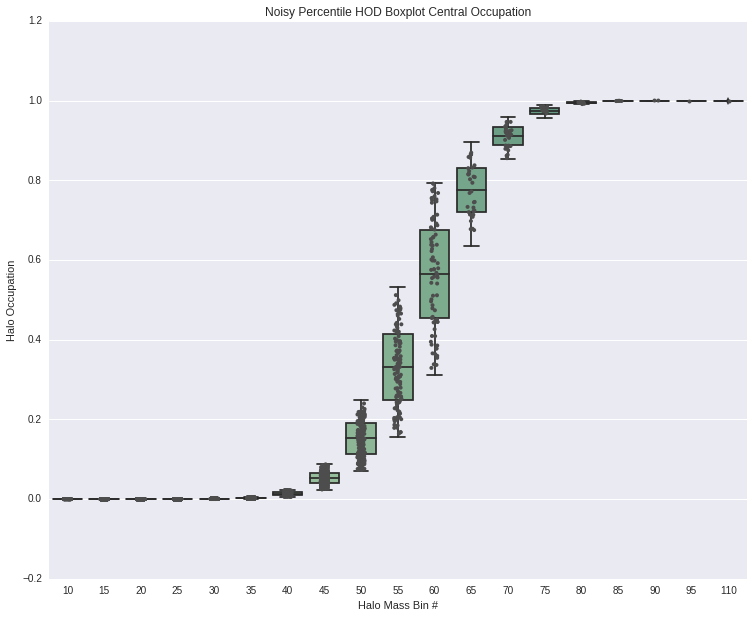

In [22]:
fig = plt.figure(figsize = (12.5,10))
#plt.plot(prim_haloprop_bins[bin_slice][sorted_idxs], baseline_result[bin_slice][sorted_idxs])
ax = sns.boxplot(x = prim_haloprop_bins[bin_slice], y = final_result_percentile[bin_slice], palette=pal)
sns.stripplot(x = prim_haloprop_bins[bin_slice][random_idxs], y = final_result_percentile[bin_slice][random_idxs],
              jitter=True, size=4, color=".3", linewidth=0)
sns.plt.title('Noisy Percentile HOD Boxplot Central Occupation')
sns.plt.xlabel('Halo Mass Bin #')
sns.plt.ylabel('Halo Occupation')

In [23]:
from scipy.stats import poisson, rankdata


def get_ranks(data):
    rank = rankdata(data, 'ordinal') - 0.5
    rank /= len(data)
    return rank


def shuffle_ranks(original_ranks, correlation):    
    if correlation >= 1.0:
        return original_ranks
    if correlation <= -1.0:
        return 1.0 - original_ranks
    
    positive_correlation = (correlation > 0)
    correlation_magnitude = abs(correlation)
    
    if correlation_magnitude < 1.0e-8:
        return get_ranks(np.random.rand(*original_ranks.shape))
    
    x = (1.0-correlation_magnitude)/correlation_magnitude    
    scale = (x**0.37 * (1.0+x**0.6) * 0.25)
    ranks = np.random.normal(loc=(original_ranks if positive_correlation else (-original_ranks)), scale=scale)
    
    return get_ranks(ranks)


def get_cen_count(rank_conc, mean_n_cen, A_cen):
    new_rank = shuffle_ranks(rank_conc, A_cen)
    return (new_rank >= mean_n_cen).astype(np.int)

In [24]:
final_result_yao = np.zeros_like(prim_haloprop)
for mass_bin in np.unique(prim_haloprop_bins):
    idx_in_bin = np.where(mass_bin == prim_haloprop_bins)
    occ_in_bin = baseline_result[idx_in_bin]
    sec_haloprop_in_bin = sec_haloprop[idx_in_bin]
    sh_perc = rank_order_percentile(sec_haloprop_in_bin)

    final_result_yao[idx_in_bin] = get_cen_count(sh_perc, occ_in_bin, A_cen= 0.0)


In [25]:
np.unique(final_result_yao)

0.0
1.0


In [26]:
np.unique(final_result_percentile)

0.0
1.49014e-08
1.49016e-08
1.49017e-08
1.49018e-08
1.49021e-08
1.49022e-08
1.49023e-08
1.49023e-08
1.49024e-08
1.49025e-08


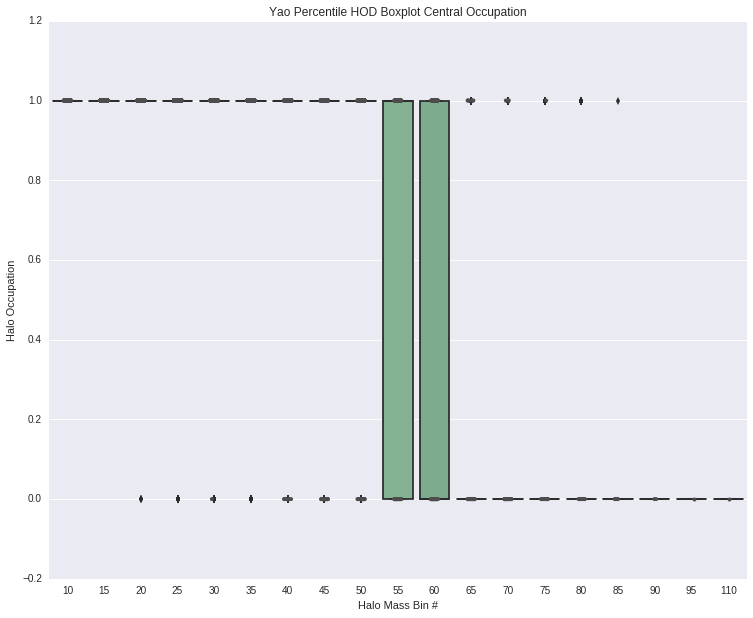

In [27]:
fig = plt.figure(figsize = (12.5,10))
#plt.plot(prim_haloprop_bins[bin_slice][sorted_idxs], baseline_result[bin_slice][sorted_idxs])
ax = sns.boxplot(x = prim_haloprop_bins[bin_slice], y = final_result_yao[bin_slice], palette=pal)
sns.stripplot(x = prim_haloprop_bins[bin_slice][random_idxs], y = final_result_yao[bin_slice][random_idxs],
              jitter=True, size=4, color=".3", linewidth=0)
sns.plt.title('Yao Percentile HOD Boxplot Central Occupation')
sns.plt.xlabel('Halo Mass Bin #')
sns.plt.ylabel('Halo Occupation')